# Estimating Home Values / Zillow Data
analyzed by Brandon Navarrete

#        ------------------------------ GOAL ------------------------------

* Find key assessed value drivers in single family properties sold in 2017  
 
    
* Construct a ML regressionn model that accurately predicts property tax value (assessed value)  
  
    
* Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?  

#       ------------------------- Wrangle Zillow Data --------------------

# Data Acquistion : 



The full DataFrame was initialized from a SQL ACE database (Jan 2023). Our data is consisting of single family resident homes, in three primary location, that were sold in 2017.

In [1]:
# Essential Imports
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import scipy.stats as stats
import statistics as s

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# sql ace credentials
import env

# self made files
import wrangle as wr
import explore as ex
import acquire as aq
import model as mo

# ignore nuisance warnings
import warnings
warnings.filterwarnings('ignore')

In [25]:
# Calling the function to make the connection to database, run the query, and store the table in the form of a dataframe
df = wr.get_zillow_data()

# print data frame shape
df.shape

(2152863, 19)

# Data Prep :

In [3]:
# calling my wrangle function to clean my data
df,df_d = wr.clean_zillow(df)

# Checking the shape of our prepped dataframe
df.shape

(2084250, 19)

# Data Splitting

In [4]:
# Calling function to split the data into train, validate, test and print shape.
train_d, validate_d, test_d = wr.split_data(df_d)

(1167180, 72) (500220, 72) (416850, 72)


In [5]:
# Calling function to split the data into train, validate, test and print shape.
train, validate, test = wr.split_data(df)

(1167180, 19) (500220, 19) (416850, 19)


#       ------------------------------ Explore ------------------------------

# Q1. What is correlated to `tax_value`(Negative/Positive)

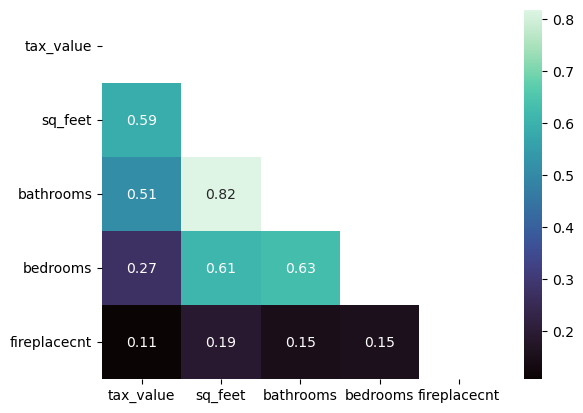

In [6]:
ex.heat_map(train[['tax_value','sq_feet','bathrooms','bedrooms','fireplacecnt']],"pearson")

Text(0.5, 1.0, 'Tax Value by Square Feet')

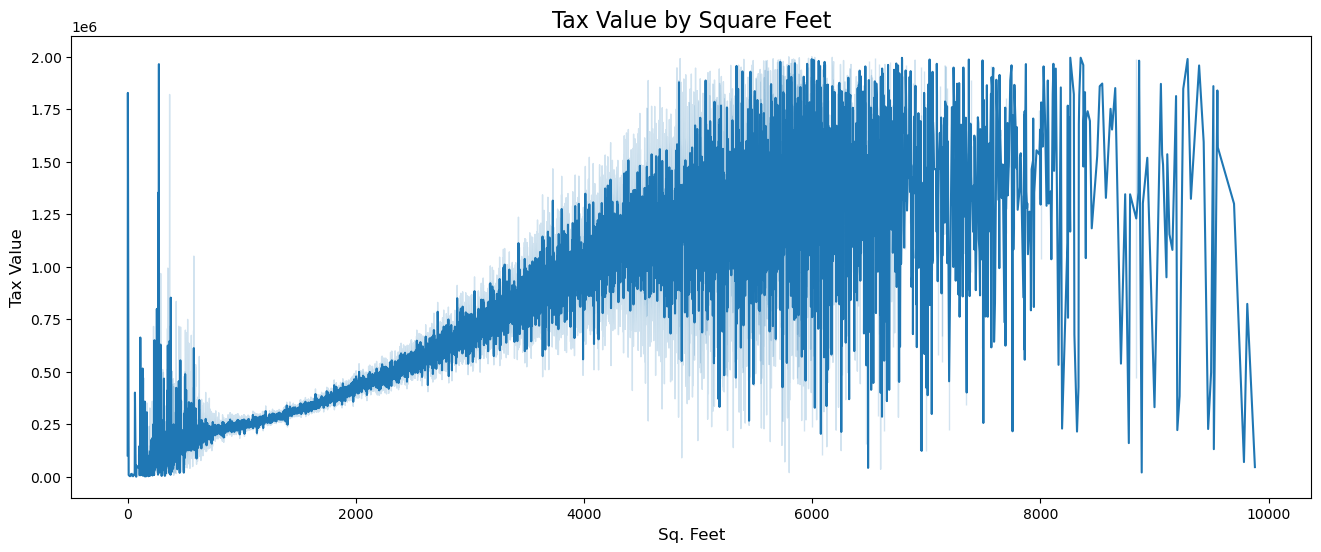

In [7]:
# creating a line plot to show the correlation between sq_feet and tax _vale
# creating a figures dimensions
plt.figure(figsize = (16,6))

# creating a seaborn line plot with a sample of 10000
sns.lineplot(data = train.sample(10000), x = train['sq_feet'],y = train['tax_value'])
# creating x and y label, as well as, title
plt.xlabel('Sq. Feet', fontsize = 12)
plt.ylabel('Tax Value', fontsize = 12)
plt.title('Tax Value by Square Feet', fontsize = 16)

# Q2. Is the mean of `tax_value` significantly different between houses that have an above average count of `bathrooms` vs the houses who have an average `bathrooms` count.

<div class="alert alert-block alert-warning">
<b>Example:</b> 

$Ho$ = Houses ,who have above average `Bathrooms` count, do not have a significant mean difference than the houses who have the average amount or less.

$Ha$ = Houses ,who have above average `Bathrooms` count, do have significant mean difference than those houses who have the average amount or less.

</div>

Text(0.5, 1.0, 'Tax Value by Bathroom Count')

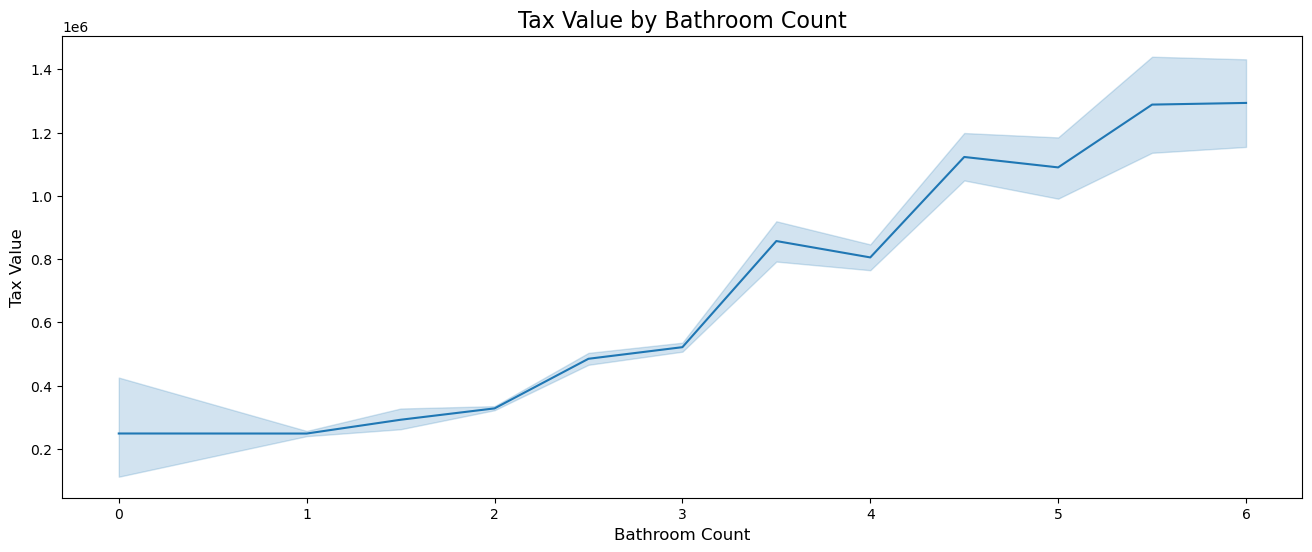

In [8]:
# visualize a line plot
# creating figures dimensions
plt.figure(figsize = (16,6))

# creating a seaborn line plot with a sample of 10000
sns.lineplot(data = train.sample(10000) , x = 'bathrooms',y = 'tax_value')

# creating labels and titles
plt.xlabel('Bathroom Count', fontsize = 12)
plt.ylabel('Tax Value', fontsize = 12)
plt.title('Tax Value by Bathroom Count', fontsize = 16)

In [9]:
# calling a fuction to return my T- Test, showing there is a significant mean difference
mo.bathroom_ttest(train)

We reject $H_{0}$
1269.0240338368853 0.0


* The p values is lower than the alpha. Rejecting the null is acceptable
* This would be a good feature for modeling

# Q3. Is the mean of `tax_value` significantly different between houses that have an above average count of `bedrooms` vs the whole house population.


<div class="alert alert-block alert-warning">
<b>Example:</b> 

$Ho$ = Houses, that have an above average `Bedrooms` count, do not have a significant mean difference than the whole house population

$Ha$ = Houses, that have an above average `Bedrooms` count, have a significant mean difference than the whole house population

</div>


Text(0.5, 1.0, 'Tax Value by Bedroom Count')

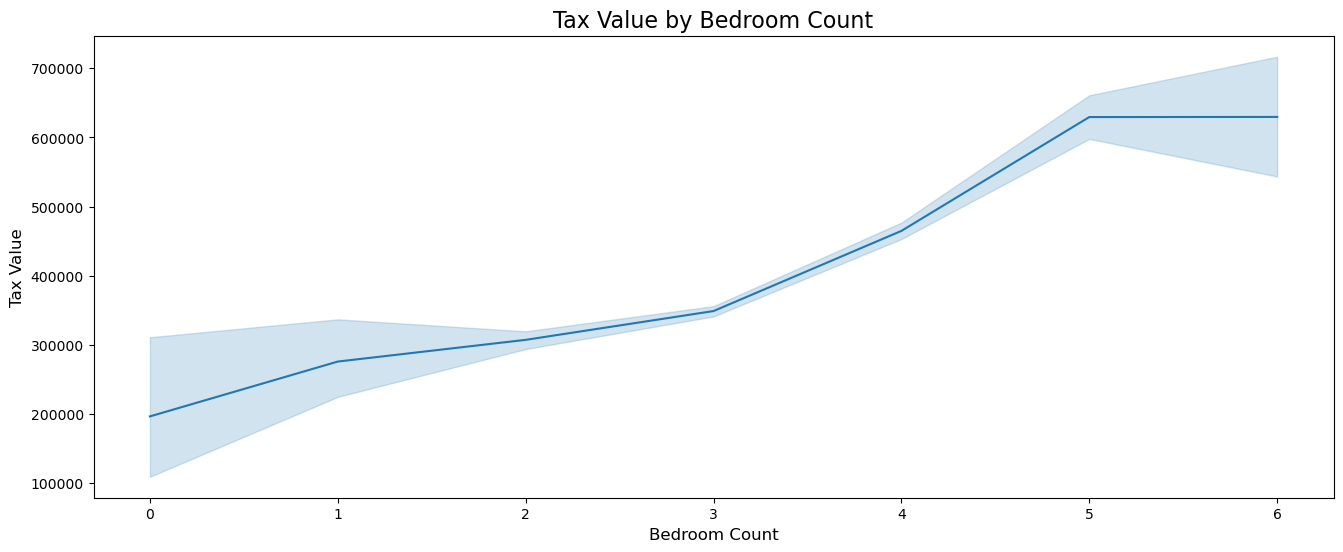

In [10]:
# visualize a line plot
plt.figure(figsize = (16,6))
sns.lineplot(data = train.sample(10000) , x = 'bedrooms',y = 'tax_value')
plt.xlabel('Bedroom Count', fontsize = 12)
plt.ylabel('Tax Value', fontsize = 12)
plt.title('Tax Value by Bedroom Count', fontsize = 16)

In [11]:
# calling a fuction to return my T- Test, showing there is a significant mean difference
mo.bedroom_ttest(train)

We reject $H_{0}$ : There is some significant difference in the mean
1325.9800343607058 0.0


#   ---------------------- Exploration Summary ------------------------

* Sq.feet has a strong positive correlation to tax value


* The mean of tax value of homes that have above average bathrooms is significantly different than those houses that have avgerage or less bathrooms


* the Mean of tax value is significantly different among houses with above average bedroom count compared to the whole population


* Features included in the model
    * sq. feet
    * bedrooms
    * bathrooms


#   ----------------------------- Modeling -------------------------------

## removing unwanted features

In [12]:
# Calling function to split the data into train, validate, test and print shape.
train_d = train_d.drop(columns=['year_built','tax_amount','fips'])
validate_d = validate_d.drop(columns=['year_built','tax_amount','fips'])
test_d =  test_d.drop(columns=['year_built','tax_amount','fips'])

## Creating X and Y Vars

In [13]:
# calling function to separate my target from the main dataframe to avoid data leakage.
x_train, y_train,x_validate,y_validate,x_test,y_test = wr.x_and_y(train_d,validate_d,test_d,'tax_value')

## Scaling Data

In [14]:
# calling function to send in my x dataframes and returned a scaled version of my numerical features.
x_train_scaled,x_validate_scaled,x_test_scaled = wr.scaled_data(x_train,x_validate,x_test,num_cols=['sq_feet'])

## Evaluations metric is RMSE

## Baseline

In [15]:
# creating my baseline RMSE
y_train,y_validate,evals = mo.baseline(y_train,y_validate)

RMSE using Mean
Train/In-Sample:  312443.43 
Validate/Out-of-Sample:  313367.61 
Difference:  924.1877069734037


RMSE using Median
Train/In-Sample:  321547.88 
Validate/Out-of-Sample:  322607.22 
Difference:  1059.3411474093446


# Linear Regression

In [16]:
# creating my linear regression model and returing in and out of sample RMSE
y_train,y_validate,evals = mo.lm_rmse(x_train_scaled,y_train,x_validate_scaled,y_validate,evals)

RMSE for OLS using LinearRegression
Training/In-Sample:  241569.97322380412 
Validation/Out-of-Sample:  4769467875957206.0 
Difference:  4769467875715636.0


# Lasso + LARS

In [17]:
# creating my Lasso + LARS model and returing in and out of sample RMSE
y_train,y_validate,evals = mo.lars_rmse(x_train_scaled,y_train,x_validate_scaled,y_validate,evals)

RMSE for Lasso + Lars
Training/In-Sample:  241654.35216784436 
Validation/Out-of-Sample:  241763.64779786346 
Difference:  109.29563001909992


# GLM

In [18]:
# creating my GLM model and returing in and out of sample RMSE
y_train,y_validate,evals = mo.glm_rmse(x_train_scaled,y_train,x_validate_scaled,y_validate,evals)

RMSE for GLM using Tweedie, power=0 & alpha=0
Training/In-Sample:  304624.4379069449 
Validation/Out-of-Sample:  241763.64779786346 
Difference:  62860.79010908143


# Polynomial Regression

In [19]:
# creating a polynomial regression dataframe and returing a linear regreassion models in and out of sample RMSE
y_train,y_validate,evals = mo.pr_rmse(x_train_scaled,y_train,x_validate_scaled,y_validate,evals)

RMSE for Polynomial Model, degrees=1
Training/In-Sample:  241569.97255147196 
Validation/Out-of-Sample:  241703.22088232238 
Difference:  133.2483308504161


In [20]:
# dataframe holding all models, respective RMSE and disclosing an overfit metrics
evals

,metric,model,rmse,overfit
0,RMSE,baseline,321547.879120,-1.059341e+03
1,RMSE,linear regression,241569.973224,-4.769468e+15
2,RMSE,Lars,241654.352168,-1.092956e+02
3,RMSE,glm,304624.437907,6.286079e+04
4,RMSE,polynomial,241569.972551,-1.332483e+02


## Model Wrap


* All models out performed the baseline on bath train and validate
* The best model is the Lasso + LARS. It has some of the lowest rmse as well as one of the best performing in terms of overfitting

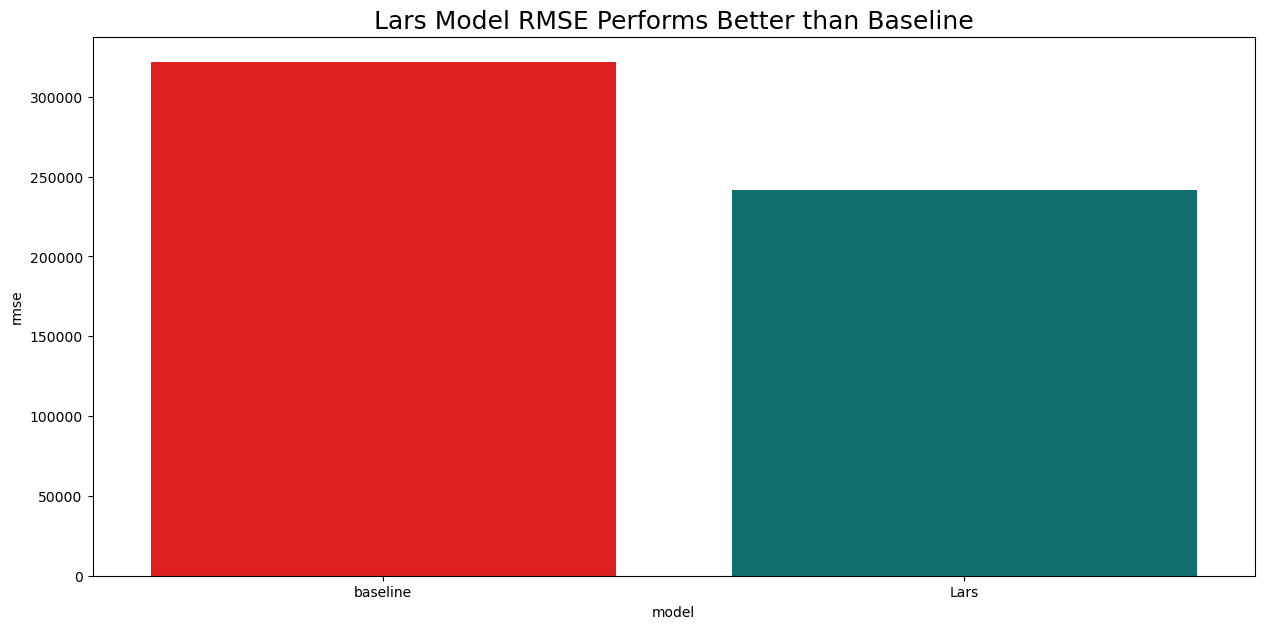

In [21]:
# function to return bar chart which shows RMSE difference
mo.model_compare(evals)

In [22]:
# function to run our best model and create an RMSE for our test dataframe
y_test = mo.test_lars_rmse(x_train_scaled,y_train,y_test,x_test_scaled) 

In [23]:
# test dataframe showing actual tax values, our baseline, and how the model performed with future data.
y_test.head()

,tax_value,baseline,lars_test_predict,lars_test_rmse
454516,280000,397830.23471,236084.250424,242368.823453
320773,105614,397830.23471,328254.430218,242368.823453
290820,970856,397830.23471,511232.394078,242368.823453
19201,113274,397830.23471,429504.486222,242368.823453
1366255,415543,397830.23471,662841.689185,242368.823453


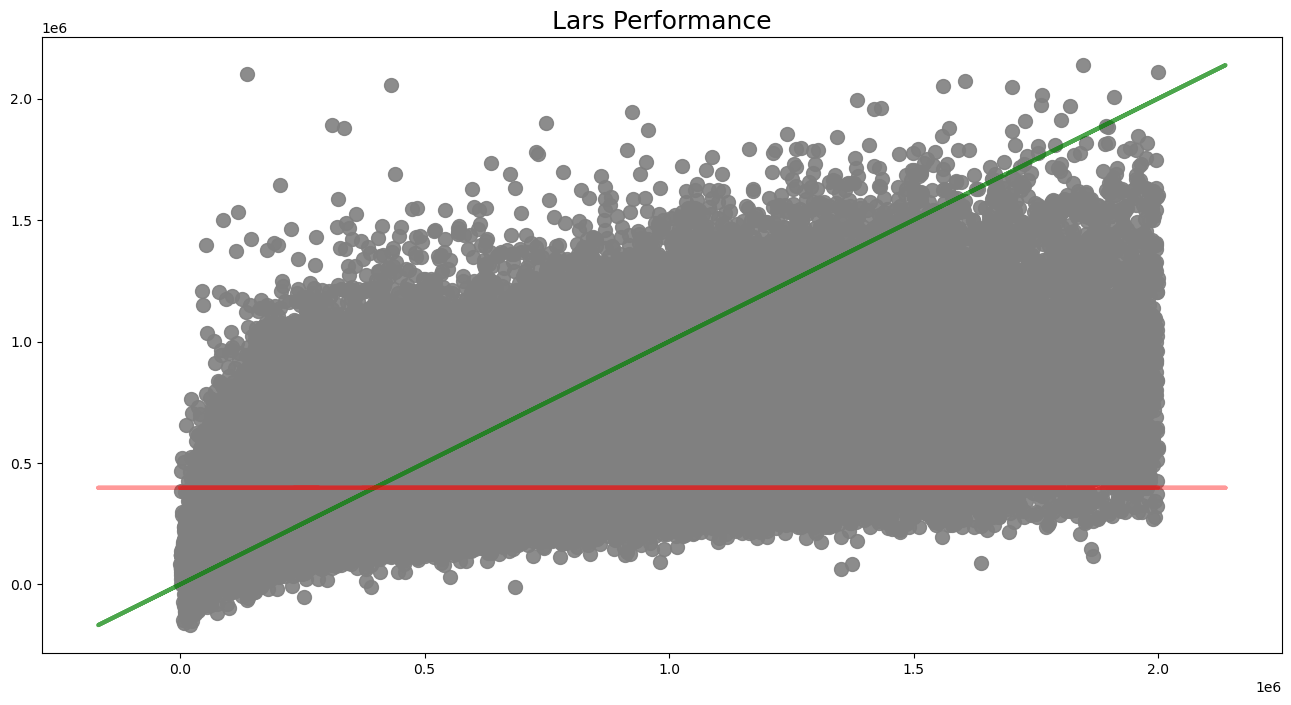

In [24]:
# A visual showing how our models best fit compares to baseline
mo.test_visual(y_test)

#   -------------------------------- Conclusion ----------------------------------

## summary


<div class="alert alert-block alert-info">
<b>Takeaways:</b>  
    
* `sq_feet`,`bedrooms`,and `bathrooms` are correlated to `tax_value`
    
* The `Lars model` is able to out perform the ~`baseline`~ with an `RMSE` of 241654.35

* The model beats the baseline by 80,000
</div>

## recommendations

<div class="alert alert-block alert-success">
<b>Recommendations:</b> 
    
* The more bedrooms, bathrooms, and square footage a house has, the more likely it is to have a greater tax value
* We should look to list single family residencies that have an above average count of these features

</div>

## Next Steps

<div class="alert alert-block alert-info">
<b>Next Steps:</b>  
    

* To improve the models accuracy we need to add more features as well as perform `kbest` and `RFE`

* Feature engineering would possibly give us better insights

* This data is not representative of the current housing market, we need to run updated data
    
</div>